In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from cryptosporidium_host_adaptation.core import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Divergent Pathways: Tracking Cryptosporidium's Host Adaptation


###  [This guide is best visualized here](https://mtinti.github.io/cryptosporidium_host_adaptation/)

## The Origin: Strain M4

Our journey begins with a single infected mouse (M4), harboring a Cryptosporidium strain that would become the progenitor of two distinct evolutionary paths. This initial host served as the critical branching point for our experimental design.

From this single origin, the parasite's story split into two parallel narratives:

### 🐭 The Murine Passage 🐭
> In this pathway, Cryptosporidium continued its journey through a series of mouse hosts, adapting to the murine environment through sequential passages:

```
M4 → M5 → M6 → M7
```

Each passage potentially allowed the parasite to optimize its survival and reproductive strategies within these genetically similar mammalian hosts.

### 🐄 The Bovine Passage 🐄
> Simultaneously, we challenged the adaptability of the same initial strain by introducing it to an entirely different mammalian lineage - neonatal calves:

```
M4 → C1 → C2 → C3
```

This cross-species transmission forced the parasite to navigate a dramatically different physiological environment, potentially driving rapid adaptation.


## 🧬 Specialized Variant Calling Strategy 🧬

The progenitor Cryptosporidium population in mouse M4 wasn't a homogeneous colony, but rather a **diverse mixture of strains**. 

>This discovery fundamentally shaped our analytical approach.

To capture the true genetic complexity within our samples, we implemented a customized variant calling pipeline:

```
┌────────────────────────────────┐
│ FREEBAYES VARIANT CALLING      │
├────────────────────────────────┤
│ • Ploidy = 1                   │
│ • --pooled-continuous option   │
└────────────────────────────────┘
```

Why This Approach Matters?

1. **Beyond Binary Detection**:
> Traditional presence/absence variant calling would have flattened the rich complexity of our samples, obscuring the very phenomenon we aimed to study.

3. **Quantitative Insight**:
> By focusing on allele frequencies rather than simple variant calls, will allow us to track subtle shifts in population genetics across hosts.


# Variant Analysis: Filtering Strategy

Our approach employed a strategic sequence of filtering steps, each addressing specific aspects of data quality:

```
┌─────────────────────────────────────┐
│ THREE-TIER FILTERING STRATEGY       │
├─────────────────────────────────────┤
│ 1. Quality-based Filtering          │
│ 2. Read Depth Optimization          │
│ 3. Variant Type Selection           │
└─────────────────────────────────────┘
```

In [ ]:
filter_variants()

Starting Variant Filtering Process
Total variants before filtering: 15901
Stage 1: QUAL filtering: 14087 Variants removed and 1814 variants left
Stage 2: FORMAT/DP filtering, DP >= 30 & DP <= 150: 355 Variants removed and 1459 variants left
Stage 3: After keeping SNPs and indels: 203 Variants removed and 1256 variants left


### Stage 1: Quality-Based Filtering

```bash
# Eliminate low confidence variant calls
bcftools filter -e 'QUAL < 30' "$INPUT_VCF" -o "$QUAL_FILTERED_VCF"
```

**Rationale**: The QUAL score represents the statistical confidence in each variant call. By establishing a minimum threshold of 30:
- We eliminated variants likely to be sequencing errors
- Retained variants with a 99.9% probability of being genuine

### Stage 2: Read Depth Optimization

```bash
# Balance between coverage requirements and anomalous amplification
bcftools view -i 'FMT/DP >= 30 & FMT/DP <= 150' "$QUAL_FILTERED_VCF" -o "$DP_FILTERED_VCF"
```

**Rationale**: Read depth optimization addressed two critical concerns:
- **Lower bound (DP ≥ 30)**: Ensured sufficient read coverage
- **Upper bound (DP ≤ 150)**: Protected against false positives from regions with anomalous read pileups which often indicate repetitive elements


### Stage 3: Variant Type Selection

```bash
# Focus on  variation subset
bcftools view -v snps,indels "$DP_FILTERED_VCF" -o "$SNP_FILTERED_VCF"
```
**Rationale**: This final step ensured our analysis focused exclusively on:

- Single nucleotide polymorphisms (SNPs)
- Small insertions and deletions (indels)

# From Raw Variants to Biological Insights 📊 with Pandas 🐼 


Leveraging the robust capabilities of Python's pandas library transformed our genetic data into a powerhouse of actionable insights.

```python
┌─────────────────────────────────────────────────────┐
│ DATA TRANSFORMATION PIPELINE                        │
├─────────────────────────────────────────────────────┤
│ 1. Load filtered VCF file                           │
│ 2. Remove ambiguous reference calls (REF = 'N')     │
│ 3. Restructure for for computing frequency          │
└─────────────────────────────────────────────────────┘
```


In [ ]:
vcf_file = "../data/filtered_final.vcf"  
df_vcf = read_vcf(vcf_file)
print(f'step 1: {df_vcf.shape}')
df_vcf=df_vcf[(df_vcf['REF']!='N')]
print(f'step 2: {df_vcf.shape}')

step 1: (1256, 16)
step 2: (945, 16)


In [ ]:
df_vcf.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,M7,M5,M4,M6,C3,C2,C1
0,CM000429,60867,.,TAAAAAAAAAAGATAT,"TAAAAAAAAAAAGATTT,TAAAAAAAAAAAGATAT,TAAAAAAAAA...",10088.400,PASS,"AB=0,0,0;ABP=0,0,0;AC=0,7,0;AF=0,1,0;AN=7;AO=1...",GT:GQ:DP:AD:RO:QR:AO:QA:GL,"2:138:82:9,2,67,2:9:296:2,67,2:24,2218,68:-172...","2:138:46:3,2,35,1:3:100:2,35,1:24,1116,34:-91....","2:138:69:4,4,59,1:4:132:4,59,1:48,1980,34:-166...","2:138:82:14,2,62,1:14:461:2,62,1:24,2092,26:-1...","2:138:57:5,1,45,1:5:163:1,45,1:12,1492,34:-119...","2:138:69:1,0,60,4:1:34:0,60,4:0,1966,136:-173....","2:138:62:4,1,50,4:4:130:1,50,4:12,1678,128:-13..."
1,CM000429,60889,.,ACCCCACT,ACCCCCACT,11705.800,PASS,AB=0;ABP=0;AC=7;AF=1;AN=7;AO=435;CIGAR=1M1I7M;...,GT:GQ:DP:AD:RO:QR:AO:QA:GL,"1:137:90:9,81:9:295:81:2686:-215.126,0","1:137:53:1,50:1:34:50:1596:-140.656,0","1:137:70:2,66:2:68:66:2184:-190.372,0","1:137:82:11,70:11:359:70:2241:-169.324,0","1:137:45:5,40:5:169:40:1237:-96.064,0","1:137:68:1,66:1:31:66:2174:-192.923,0","1:137:69:4,62:4:126:62:2002:-168.787,0"
2,CM000429,76625,.,A,G,265.872,PASS,AB=0;ABP=0;AC=1;AF=0.142857;AN=7;AO=248;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA:GL,"0:131:104:76,28:76:2560:28:952:0,-144.672","0:131:80:52,28:52:1738:28:930:0,-72.6994","0:131:84:50,34:50:1596:34:1156:0,-39.5691","0:131:89:61,28:61:2066:28:944:0,-100.949","1:131:83:36,47:36:1216:47:1598:-34.3706,0","0:131:112:78,34:78:2630:34:1126:0,-135.322","0:131:112:63,49:63:2126:49:1658:0,-42.1062"
3,CM000429,82019,.,A,T,8192.190,PASS,AB=0;ABP=0;AC=7;AF=1;AN=7;AO=410;CIGAR=1X;DP=5...,GT:GQ:DP:AD:RO:QR:AO:QA:GL,"1:160:98:9,89:9:306:89:2994:-241.841,0","1:160:51:15,36:15:510:36:1186:-60.8115,0","1:160:86:19,67:19:638:67:2240:-144.133,0","1:160:90:15,75:15:488:75:2488:-179.952,0","1:160:70:26,44:26:862:44:1472:-54.8869,0","1:160:81:31,50:31:1046:50:1662:-55.4182,0","1:160:71:22,49:22:748:49:1666:-82.5935,0"
4,CM000429,82192,.,G,A,6765.840,PASS,AB=0;ABP=0;AC=6;AF=0.857143;AN=7;AO=398;CIGAR=...,GT:GQ:DP:AD:RO:QR:AO:QA:GL,"1:134:104:11,93:11:374:93:3124:-247.418,0","1:134:67:20,47:20:658:47:1598:-84.5836,0","1:134:75:25,50:25:842:50:1692:-76.4771,0","1:134:102:26,76:26:846:76:2568:-154.943,0","0:0:53:28,25:28:944:25:850:0,-8.45503","1:134:92:35,57:35:1190:57:1938:-67.2984,0","1:134:83:33,50:33:1084:50:1692:-54.7114,0"


## 📝 From VCF Fields to counting reads for each allele

```python
┌─────────────────────────────────────────────────────────┐
│ ALLELE FREQUENCY CALCULATION COMPONENTS                 │
├─────────────────────────────────────────────────────────┤
│ RO: Reference Allele Observation count                  │
│ AO: Alternate Allele Observation count                  │
│ DP: Total Read Depth at position                        │
│                                                         │
│ Allele Frequency = AO / DP                              │
└─────────────────────────────────────────────────────────┘
```


In [ ]:
df_allele_counts = expand_multiallelic_variants(df_vcf)
df_allele_counts.to_csv("../data/allele_counts_expanded.tsv", sep="\t", index=False)
print("✅ Extracted and expanded allele counts saved to allele_counts_expanded.tsv")

✅ Extracted and expanded allele counts saved to allele_counts_expanded.tsv


In [ ]:
df_allele_counts.head()

,#CHROM,POS,REF,ALT,RO_M7,DP_M7,AO_M7,RO_M5,DP_M5,AO_M5,...,AO_M6,RO_C3,DP_C3,AO_C3,RO_C2,DP_C2,AO_C2,RO_C1,DP_C1,AO_C1
0,CM000429,60867,TAAAAAAAAAAGATAT,TAAAAAAAAAAAGATTT,9,82,2,3,46,2,...,2,5,57,1,1,69,0,4,62,1
1,CM000429,60867,TAAAAAAAAAAGATAT,TAAAAAAAAAAAGATAT,9,82,67,3,46,35,...,62,5,57,45,1,69,60,4,62,50
2,CM000429,60867,TAAAAAAAAAAGATAT,TAAAAAAAAAAAAGATAT,9,82,2,3,46,1,...,1,5,57,1,1,69,4,4,62,4
3,CM000429,60889,ACCCCACT,ACCCCCACT,9,90,81,1,53,50,...,70,5,45,40,1,68,66,4,69,62
4,CM000429,76625,A,G,76,104,28,52,80,28,...,28,36,83,47,78,112,34,63,112,49


## 📝 Keep variants where one of the call as at least 5 supporting reads

In [ ]:
print(df_allele_counts.shape)
df_allele_counts = df_allele_counts[
df_allele_counts[[n for n in df_allele_counts.columns if n.startswith('AO')]].max(axis=1)>=5]
print(df_allele_counts.shape)

(1238, 25)
(1238, 25)


In [ ]:
df_af = compute_frequencies(df_allele_counts)
df_af.to_csv("../data/allele_frequencies.tsv", sep="\t", index=False)
print("✅ Allele frequencies saved to allele_frequencies.tsv")

✅ Allele frequencies saved to allele_frequencies.tsv


In [ ]:
df_af.head()

,#CHROM,POS,REF,ALT,AF_M7,AF_M5,AF_M4,AF_M6,AF_C3,AF_C2,AF_C1
1,CM000429,60867,TAAAAAAAAAAGATAT,TAAAAAAAAAAAGATAT,0.817073,0.760870,0.855072,0.756098,0.789474,0.869565,0.806452
3,CM000429,60889,ACCCCACT,ACCCCCACT,0.900000,0.943396,0.942857,0.853659,0.888889,0.970588,0.898551
4,CM000429,76625,A,G,0.269231,0.350000,0.404762,0.314607,0.566265,0.303571,0.437500
5,CM000429,82019,A,T,0.908163,0.705882,0.779070,0.833333,0.628571,0.617284,0.690141
6,CM000429,82192,G,A,0.894231,0.701493,0.666667,0.745098,0.471698,0.619565,0.602410


## 🔍 Frequency Distribution Analysis

> With our extracted allele frequencies in hand, we could now explore how these frequencies were distributed across our samples



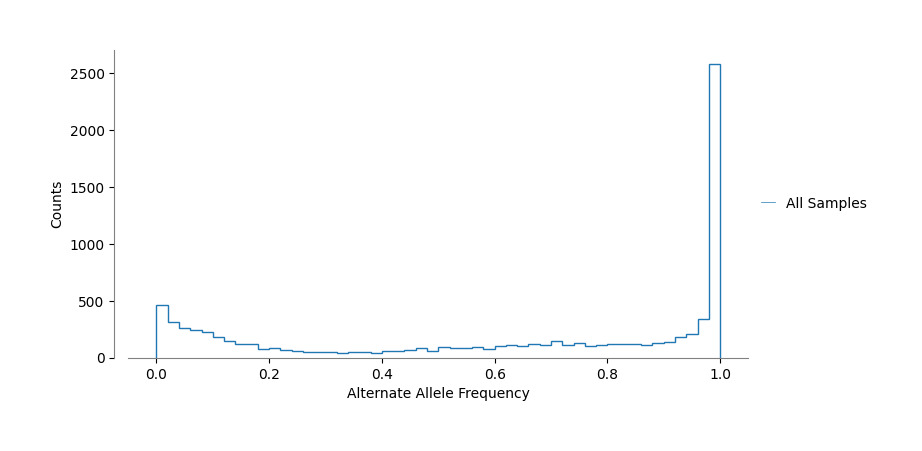

In [ ]:
fig,ax=plt.subplots(figsize=(8,4))
data=pd.read_csv('../data/allele_frequencies.tsv',sep='\t')
tmp = pd.Series(data.iloc[:,4:].values.flatten())
tmp.name='All Samples'
tmp.plot(kind='hist',histtype='step',bins=50,ax=ax,linewidth=1)
ax.set_xlabel('Alternate Allele Frequency')
ax.set_ylabel('Counts')
mod_hist_legend(ax)
clean_axes(ax)
plt.show()

- **Expected in clonal samples**: Frequencies clustered at extremes (0 or 1)
  - 0: Reference allele only
  - 1: Alternative allele only

> *"The presence of allele frequencies distinctly deviating from the expected 0/1 pattern confirms our hypothesis that mouse M4 harbors a heterogeneous Cryptosporidium population with multiple strains coexisting"*


# 🔬 Focusing on Single Nucleotide Variants

> To gain deeper insight into the evolutionary dynamics of our Cryptosporidium populations, we narrowed our analysis to focus specifically on Single Nucleotide Variants (SNVs).


```python
┌─────────────────────────────────────────────────────────┐
│ SNV CLUSTERING WORKFLOW                                 │
├─────────────────────────────────────────────────────────┤
│ 1. Filter dataset to retain only SNVs                   │    
│ 2. Normalize frequencies (divide by max frequency)      │
│ 4. Include only variants with >30% frequency            │
│    difference between any two samples                   │
│ 5. Perform hierarchical clustering                      │
│ 6. Visualize dendrogram                                 │
└─────────────────────────────────────────────────────────┘
```


step 1 starting variants: (1238, 11)
step 2 only snv variants: (511, 11)
selected variants: (129, 7)


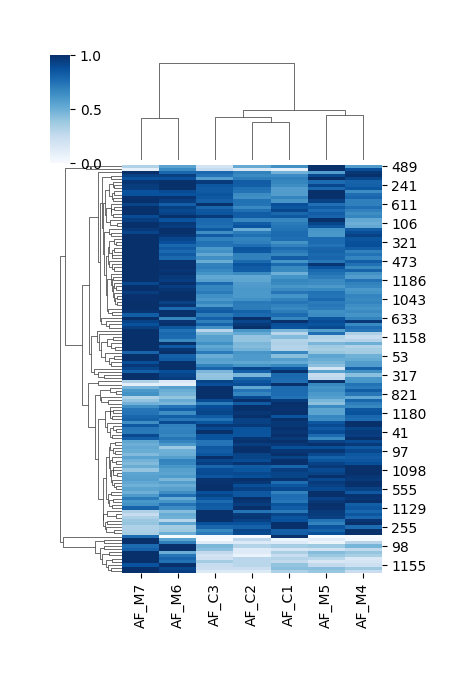

In [ ]:
data=pd.read_csv('../data/allele_frequencies.tsv',sep='\t')
print(f'step 1 starting variants: {data.shape}')
data=data[(data['ALT'].str.len()==1)]
print(f'step 2 only snv variants: {data.shape}')

clustering_data = data[['AF_M7', 'AF_M5', 'AF_M6', 'AF_M4','AF_C3', 'AF_C2', 'AF_C1']]
clustering_data = clustering_data.divide(clustering_data.max(axis=1),axis=0)
clustering_max=clustering_data.max(axis=1)
clustering_min=clustering_data.min(axis=1)
clustering_data = clustering_data[(clustering_max-clustering_min)>0.3]
print('selected variants:', clustering_data.shape)
sns.clustermap(clustering_data,cmap='Blues',figsize=(4,6))
plt.savefig('../data/Allele_Frequency_SNVs.svg')
plt.savefig('../data/Allele_Frequency_SNVs.png')


## 🧬 Distinct Evolutionary Trajectories Revealed

The hierarchical clustering dendrogram revealed several patterns:

1. **Clear Host-Species Separation**: 
   > *"The clustering  segregated bovine and murine samples, suggesting host specific pressure on the Cryptosporidium population."*

2. **Temporal Evolution in Murine Hosts**:
   > *"The murine samples displayed a clear temporal progression, with M6 and M7 clustering distinctly from the earlier passages (M4-M5)."*

3. **Similarity Between Early Murine and Bovine Samples**:
   > *"The three bovine samples (C1-C3) showed greater similarity to the early murine passages (M4-M5) than to the later murine passages (M6-M7). 
   Bovine adaptation might be slower to kick in."*

## 🔍 Frequency Distribution Analysis SNVs

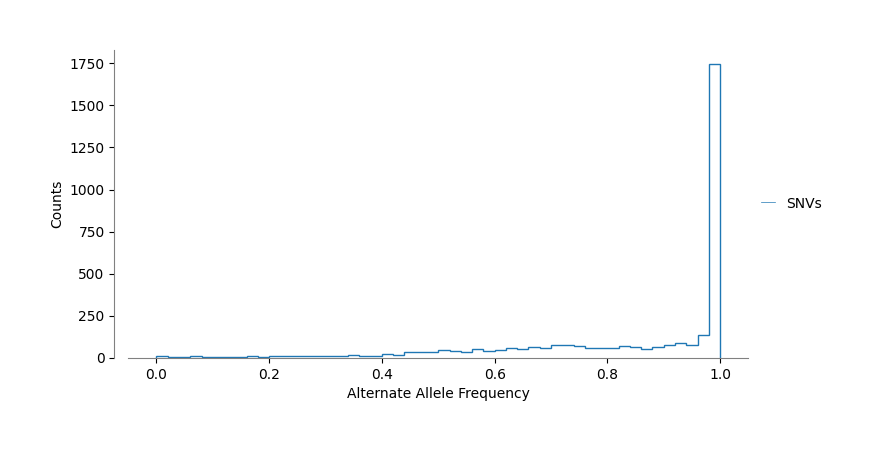

In [ ]:
fig,ax=plt.subplots(figsize=(8,4))
tmp = pd.Series(data.iloc[:,4:].values.flatten())
tmp.name='SNVs'
tmp.plot(kind='hist',histtype='step',bins=50,ax=ax,linewidth=1)
ax.set_xlabel('Alternate Allele Frequency')
ax.set_ylabel('Counts')
mod_hist_legend(ax)
clean_axes(ax)
plt.show()

# 🔬 Focusing on INDELS
> Having established clear evolutionary patterns through SNV analysis, we extended our investigation to insertions and deletions (INDELs) using the same strategy

step 1 starting variants: (1238, 11)
step 2 only snv variants: (727, 11)
selected variants: (444, 7)


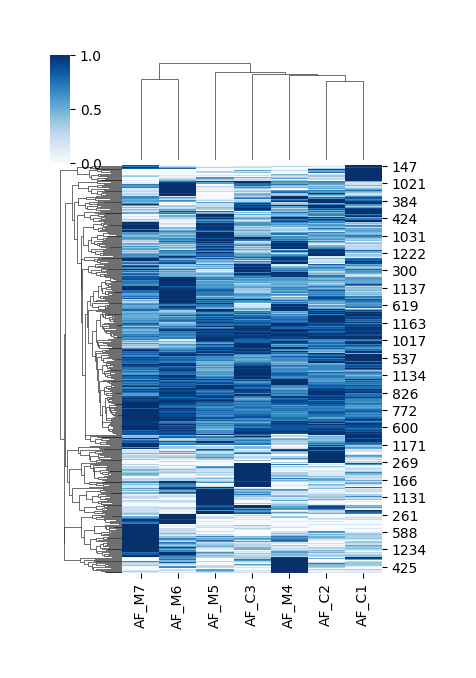

In [ ]:
data=pd.read_csv('../data/allele_frequencies.tsv',sep='\t')
print(f'step 1 starting variants: {data.shape}')
data=data[(data['ALT'].str.len()!=1)]
print(f'step 2 only snv variants: {data.shape}')

clustering_data = data[['AF_M7', 'AF_M5', 'AF_M6', 'AF_M4','AF_C3', 'AF_C2', 'AF_C1']]
clustering_data = clustering_data.divide(clustering_data.max(axis=1),axis=0)
clustering_max=clustering_data.max(axis=1)
clustering_min=clustering_data.min(axis=1)
clustering_data = clustering_data[(clustering_max-clustering_min)>0.3]
print('selected variants:', clustering_data.shape)
sns.clustermap(clustering_data,cmap='Blues',figsize=(4,6))
plt.savefig('../data/Allele_Frequency_INDELs.svg')
plt.savefig('../data/Allele_Frequency_INDELs.png')

## 🧬 Distinct Clustering Patterns in INDELs

When applying our clustering strategy to INDELs, we observed strikingly different patterns from those seen with SNVs

>*"The most striking feature of our INDEL analysis is the emergence of sample specific variant clusters"*  or in ther words, sample specific groups of INDELs



## 🔍 Frequency Distribution Analysis SNVs

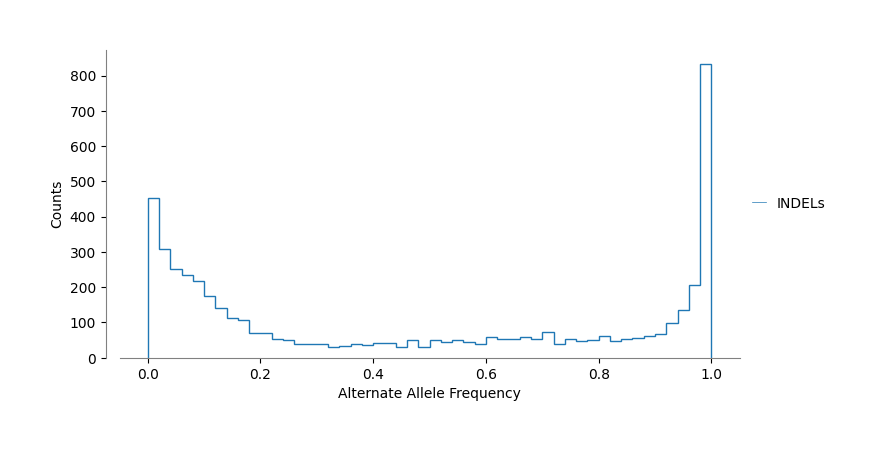

In [ ]:
fig,ax=plt.subplots(figsize=(8,4))
tmp = pd.Series(data.iloc[:,4:].values.flatten())
tmp.name='INDELs'
tmp.plot(kind='hist',histtype='step',bins=50,ax=ax,linewidth=1)
ax.set_xlabel('Alternate Allele Frequency')
ax.set_ylabel('Counts')
mod_hist_legend(ax)
clean_axes(ax)
plt.show()

## 📊 Accelerated INDEL Evolution

> *"The predominance of low-frequency INDELs compared to the SNVs frequencies suggests fundamentally different evolutionary dynamics: while SNVs appear to undergo gradual selection toward fixation, INDELs display a pattern of rapid emergence and turnover, generating a diverse array of transient subpopulations within each sample."*

# Genome-Wide Distribution: Mapping Variants Across the Cryptosporidium Genome

## 🔍 Taking a Broader Perspective

> Having explored the dynamics of both SNVs and INDELs through clustering analyses, we stepped back to examine the holistic picture of where these variants are distributed across the Cryptosporidium genome.


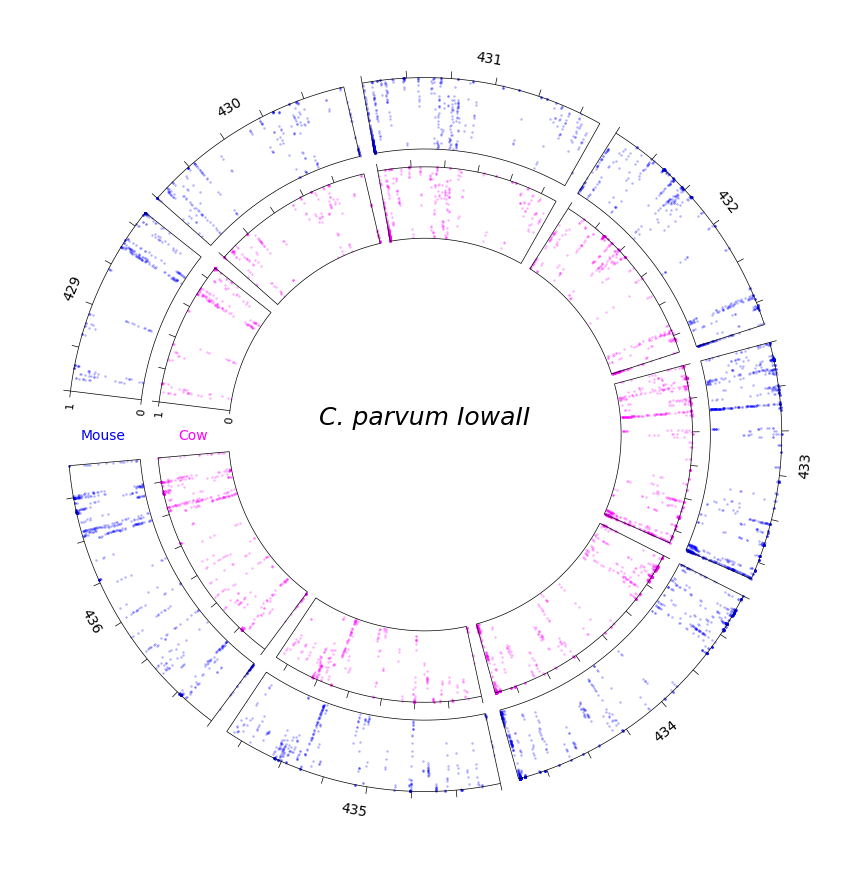

In [ ]:
data=pd.read_csv('../data/allele_frequencies.tsv',sep='\t')
make_circos_plot(data)

## 🧬 Genomic Distribution Patterns

The circular genome plot revealed several striking patterns:

> *"The distribution of variants across the Cryptosporidium genome is strikingly non-random, with clear hotspots of both SNVs and INDELs congregating in specific genomic regions other then close to the telomers."*



### Reproducibility

Install latest from the GitHub [repository][repo]:

```sh
$ pip install git+https://github.com/mtinti/cryptosporidium_host_adaptation.git
```



[repo]: https://github.com/mtinti/cryptosporidium_host_adaptation


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()